# Diabetes Prediction

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Dataset

df = pd.read_csv('./dataset/diabetes_012_health_indicators_BRFSS2015.csv')

In [3]:
# Preprocessing: Drop Unwanted Columns

drop_cols = ['Education','Income','AnyHealthcare','NoDocbcCost','MentHlth','PhysHlth']
df = df.drop(columns=drop_cols)

# Cek missing values
print("Missing Values per Column:\n", df.isnull().sum())
if df.isnull().sum().sum() > 0:
    for col in df.columns:
        if df[col].dtype in ['int64','float64']:
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna(df[col].mode()[0])
    print("Missing values handled.")
else:
    print("No missing values detected.")

# Pastikan tipe data numeric
for c in df.columns:
    if df[c].dtype == 'float64':
        # kalau semua bilangan bulat sebaiknya convert ke int
        if np.all(df[c].dropna() == df[c].dropna().astype(int)):
            df[c] = df[c].astype('int64')

# Tampilkan distribusi kelas target
print('\nTarget class distribution:')
print(df['Diabetes_012'].value_counts(normalize=True))

Missing Values per Column:
 Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
GenHlth                 0
DiffWalk                0
Sex                     0
Age                     0
dtype: int64
No missing values detected.

Target class distribution:
Diabetes_012
0    0.842412
2    0.139333
1    0.018255
Name: proportion, dtype: float64


<Figure size 1000x400 with 0 Axes>

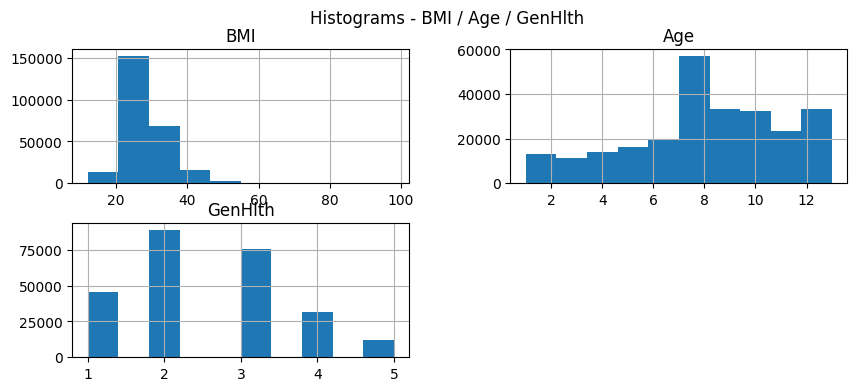

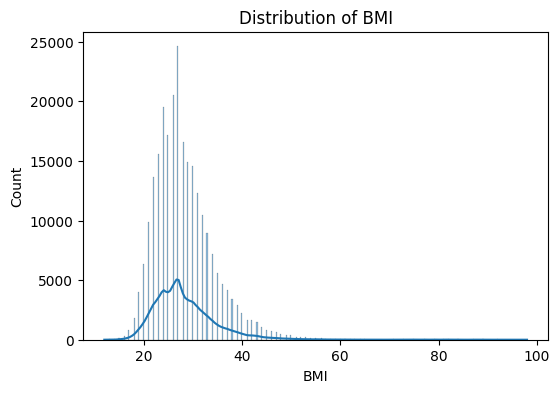

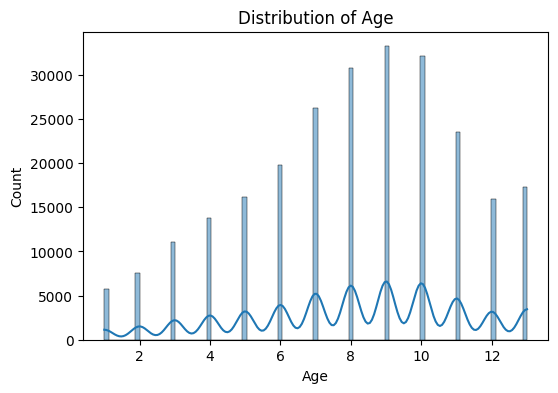

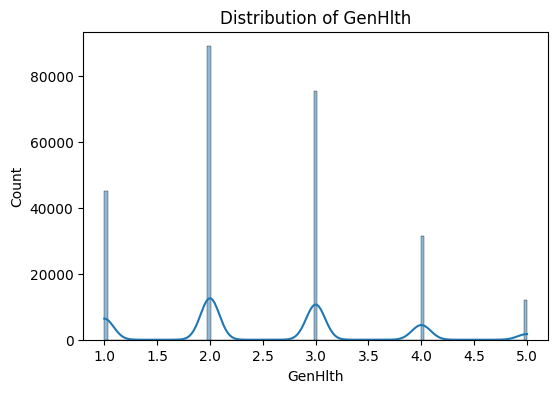

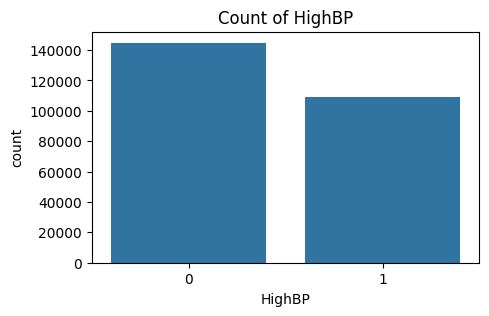

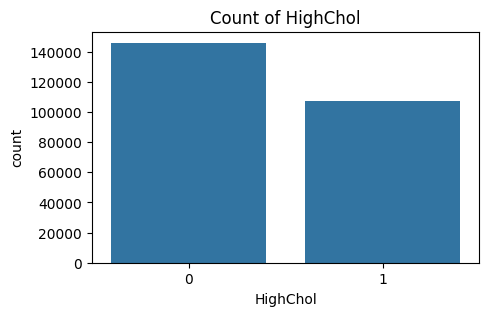

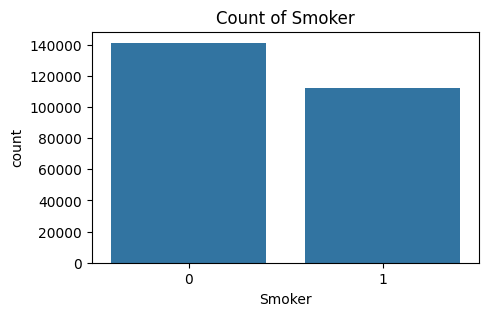

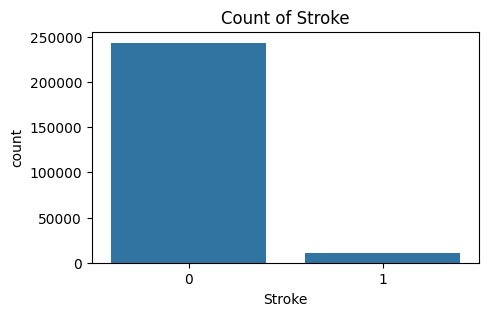

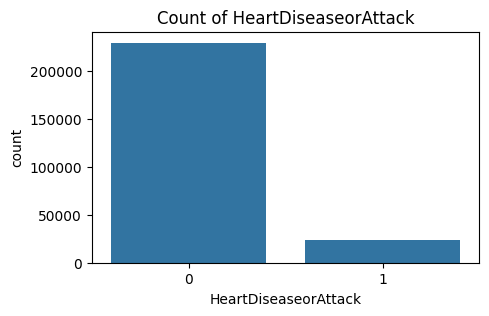

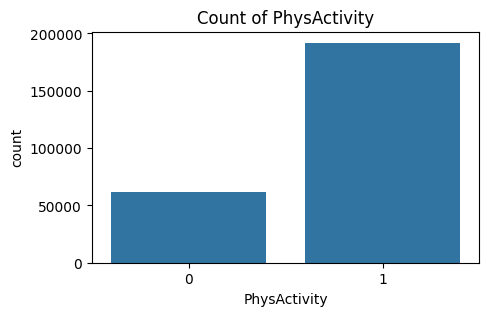

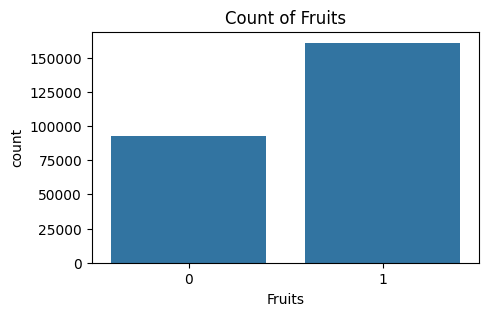

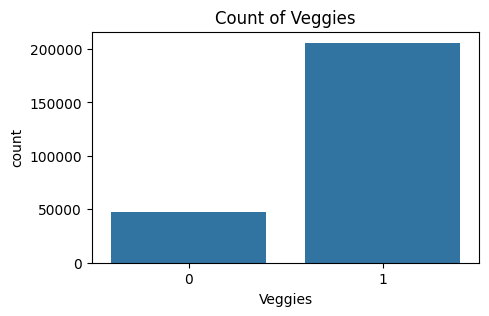

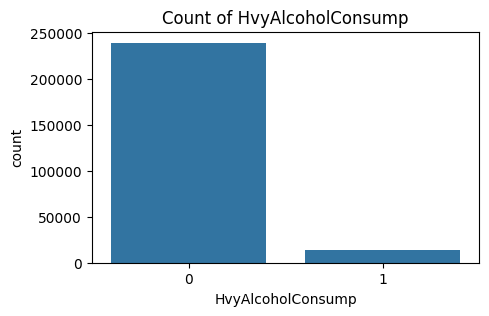

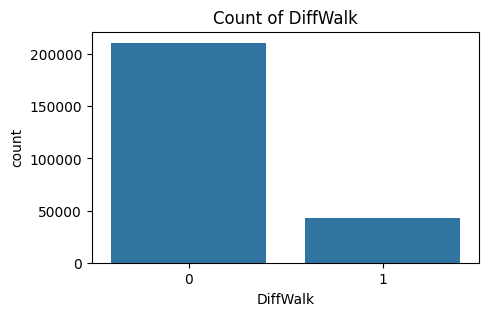

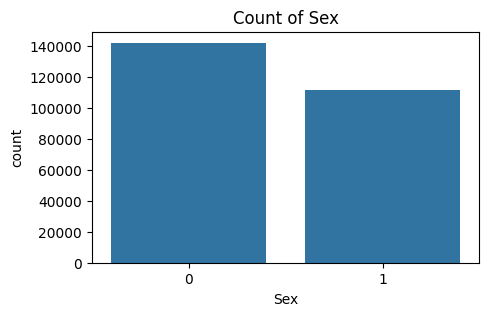

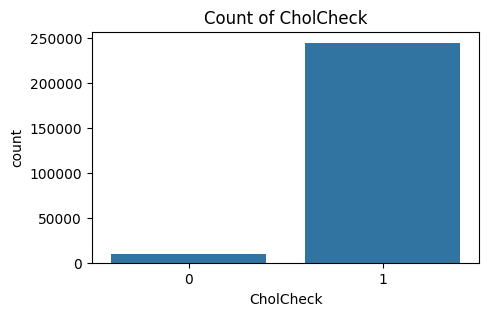

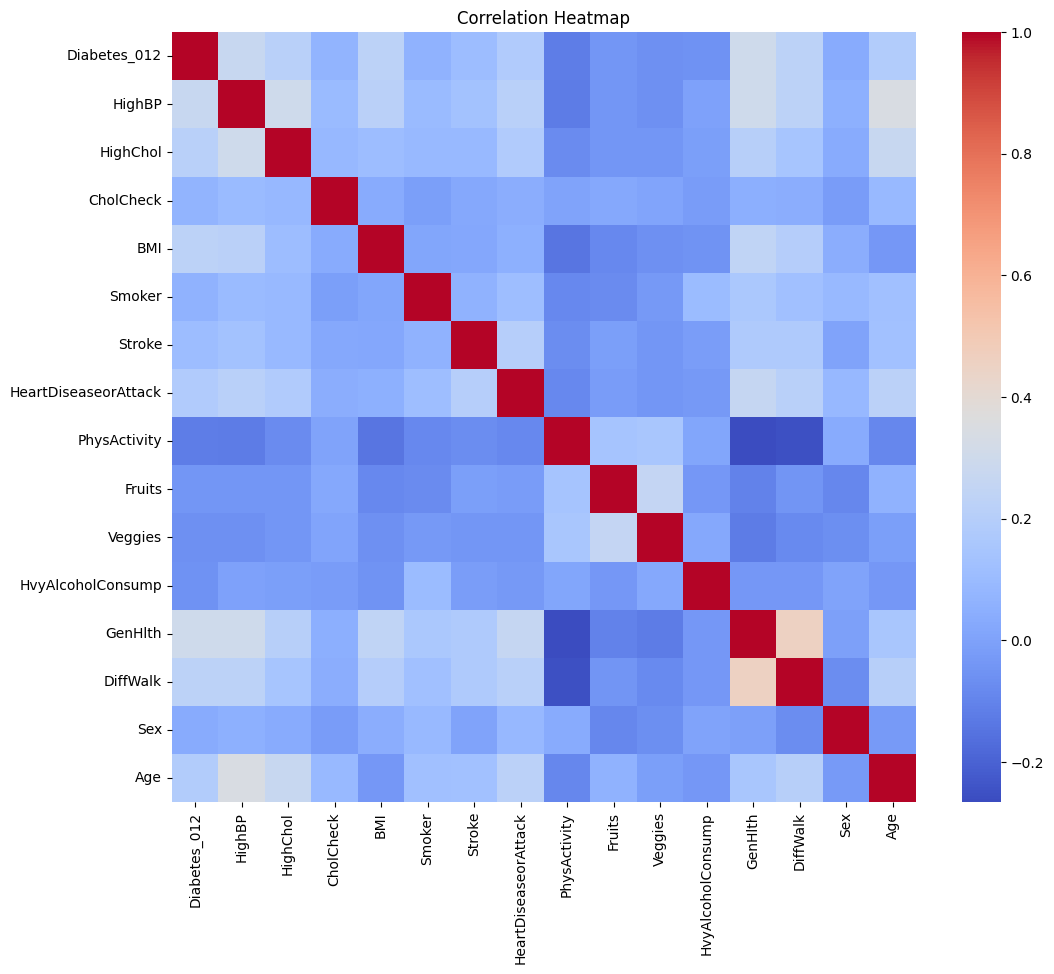

In [4]:
# EDA: Numerical Distributions

num_cols = ['BMI','Age','GenHlth']

# Histogram
plt.figure(figsize=(10,4))
df[num_cols].hist(figsize=(10,4))
plt.suptitle('Histograms - BMI / Age / GenHlth')
plt.show()

# Distribution plots
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

# Barplots untuk fitur biner penting
binary_cols = ['HighBP','HighChol','Smoker','Stroke','HeartDiseaseorAttack','PhysActivity','Fruits','Veggies','HvyAlcoholConsump','DiffWalk','Sex','CholCheck']
for col in binary_cols:
    plt.figure(figsize=(5,3))
    sns.countplot(x=df[col])
    plt.title(f'Count of {col}')
    plt.show()

# Correlation heatmap (praktis untuk melihat korelasi)
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [5]:
# Split Features and Target

X = df.drop('Diabetes_012', axis=1)
y = df['Diabetes_012']

In [6]:
# Train-Test Split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
# Scaling Numerical Features

scaler = StandardScaler()
num_cols = ['BMI','Age','GenHlth']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Save scaler for deployment later
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [8]:
# Random Forest

rf = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
print('Random Forest Accuracy:', rf_acc)
print(classification_report(y_test, rf_pred))

Random Forest Accuracy: 0.7664971617786187
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     42741
           1       0.02      0.05      0.03       926
           2       0.33      0.32      0.32      7069

    accuracy                           0.77     50736
   macro avg       0.41      0.41      0.41     50736
weighted avg       0.78      0.77      0.78     50736



In [9]:
# XGBoost

xgb = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    num_class=3,
    learning_rate=0.05,
    max_depth=6,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_pred)
print('XGBoost Baseline Accuracy:', xgb_acc)
print(classification_report(y_test, xgb_pred))

xgb = XGBClassifier(objective='multi:softprob',
                    eval_metric='mlogloss',
                    num_class=3,
                    learning_rate=0.05, 
                    max_depth=6, 
                    n_estimators=300, 
                    subsample=0.8, 
                    colsample_bytree=0.8, 
                    n_jobs=-1
                    )

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_pred)
print('\nXGBoost Baseline Accuracy:', xgb_acc)
print(classification_report(y_test, xgb_pred))

XGBoost Baseline Accuracy: 0.8488844213181962
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42741
           1       0.00      0.00      0.00       926
           2       0.55      0.18      0.27      7069

    accuracy                           0.85     50736
   macro avg       0.47      0.39      0.40     50736
weighted avg       0.80      0.85      0.81     50736


XGBoost Baseline Accuracy: 0.8488844213181962
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42741
           1       0.00      0.00      0.00       926
           2       0.55      0.18      0.27      7069

    accuracy                           0.85     50736
   macro avg       0.47      0.39      0.40     50736
weighted avg       0.80      0.85      0.81     50736



In [10]:
# Hyperparameter Tuning: RandomizedSearchCV for XGBoost

param_dist = {
    'max_depth': [4,5,6,7,8],
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6,0.7,0.8,0.9,1.0],
    'n_estimators': [200, 300, 400, 600],
    'gamma': [0, 0.1, 0.2, 0.3, 0.5],
    'min_child_weight': [1,3,5,7]
}

xgb_base = XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', num_class=3, n_jobs=-1)

search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=30,
    scoring='accuracy',
    cv=3,
    verbose=2,
    random_state=42
)

# Run search (may take some time depending on machine)
search.fit(X_train, y_train)

print('\nBest params found:')
print(search.best_params_)
best_xgb = search.best_estimator_


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=600, subsample=0.6; total time=   4.7s
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=600, subsample=0.6; total time=   5.1s
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=600, subsample=0.6; total time=   5.0s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=200, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=200, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=200, subsample=0.6; total time=   1.3s
[CV] END colsample_bytree=0.9, gamma=0.5, learning_rate=0.01, max_

In [11]:
# Evaluate tuned model

best_pred = best_xgb.predict(X_test)
best_acc = accuracy_score(y_test, best_pred)
print('\nTuned XGBoost Accuracy:', best_acc)
print(classification_report(y_test, best_pred))



Tuned XGBoost Accuracy: 0.8489829706717124
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42741
           1       0.00      0.00      0.00       926
           2       0.56      0.18      0.27      7069

    accuracy                           0.85     50736
   macro avg       0.47      0.38      0.39     50736
weighted avg       0.80      0.85      0.81     50736



In [12]:
# Save best model

joblib.dump(best_xgb, 'xgb_best_model.pkl')
print('Saved tuned XGBoost model to xgb_best_model.pkl and scaler to scaler.pkl')

Saved tuned XGBoost model to xgb_best_model.pkl and scaler to scaler.pkl


In [13]:
# Final comparison

import pandas as pd
results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'XGBoost (Tuned)'],
    'Accuracy': [rf_acc, xgb_acc, best_acc]
})
print('\nFinal Accuracy Comparison:')
print(results)


Final Accuracy Comparison:
             Model  Accuracy
0    Random Forest  0.766497
1          XGBoost  0.848884
2  XGBoost (Tuned)  0.848983


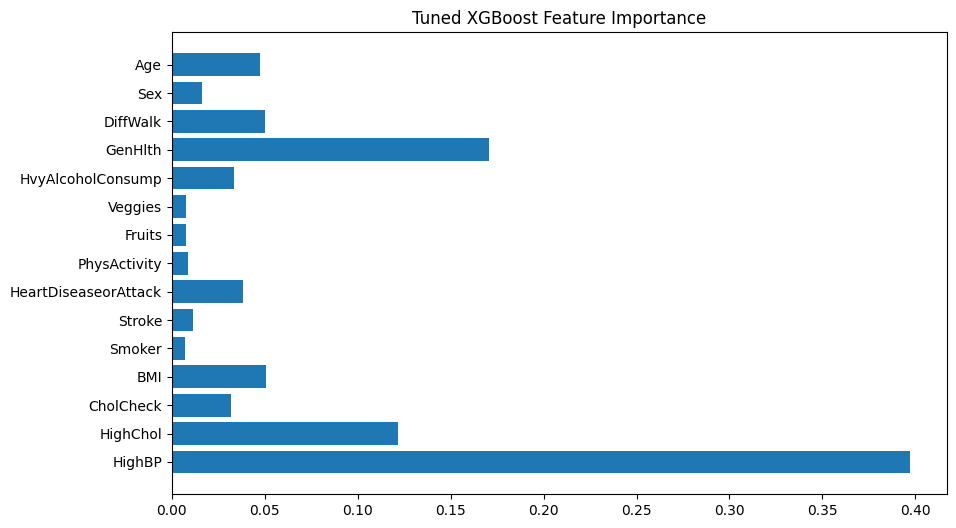

In [14]:
# Feature importance (tuned XGBoost)    

plt.figure(figsize=(10,6))
importance = best_xgb.feature_importances_
plt.barh(X.columns, importance)
plt.title('Tuned XGBoost Feature Importance')
plt.show()